# Timeseries Classification
This example assumes you've read `advanced.py`, and covers:

  - Timeseries binary classification on real data
  - Windowed data format; sequence length 188, 4 windows -> 47 points per window
  - Binary classification visuals
  - Using class weights to handle imbalance

In [1]:
import deeptrain
deeptrain.util.misc.append_examples_dir_to_sys_path()  # for `from utils import`

from utils import TS_CONFIGS as C
from utils import init_session, make_timeseries_classifier
from see_rnn import features_1D, rnn_histogram, rnn_heatmap

### Dataset info
  - PTB Diagnostic ECG Database - https://www.kaggle.com/shayanfazeli/heartbeat
  - Number of samples: 14552
  - Number of channels: 1
  - Number of classes: 2 (binary classification)
  - Sampling frequency: 125 Hz
  - Datapoints per sequence: 188

### Configure TrainGenerator, DataGenerators, & model

In [2]:
batch_size = 128
window_size = 188 / 4.  # use 4 windows
assert window_size.is_integer()  # ensure it divides sequence length
window_size = int(window_size)

# Make DataGenerator divide up the (128, 188, 1)-shaped batch
# into 4 slices shaped (128, 47, 1) each, feeding one at a time to model
C['datagen'    ]['preprocessor'] = 'timeseries'
C['val_datagen']['preprocessor'] = 'timeseries'
C['datagen'    ]['preprocessor_configs'] = {'window_size': window_size}
C['val_datagen']['preprocessor_configs'] = {'window_size': window_size}

C['model']['batch_shape'] = (batch_size, window_size, 1)

  - `eval_fn`: need `'predict'` for visuals and custom metrics
  - `key_metric`: `'f1_score'` for imbalanced binary classification
  - `val_metrics`: true positive rate & true negative rate are "class accuracies",
     i.e. class-1 acc & class-2 acc
  - `plot_first_pane_max_vals`: plot only validation loss in first plot window,
    the rest on second, to avoid clutter and keep losses together
  - `class_weights`: "normal" is the minority class; 3x more "abnormal" samples
  - others: see utils.py

In [3]:
C['traingen'].update(dict(
    eval_fn='predict',
    key_metric='f1_score',
    val_metrics=('loss', 'tnr', 'tpr'),
    plot_first_pane_max_vals=1,
    class_weights={0: 3, 1: 1},
    iter_verbosity=0,
    plot_configs={'fig_kw': {'figsize': (8, 5)},
                  '0': {'legend_kw': {'fontsize': 11}},
                  '1': {'legend_kw': {'fontsize': 11}}},
))
tg = init_session(C, make_timeseries_classifier)

Discovered dataset with matching format
Discovered dataset with matching format
103 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated

Discovered dataset with matching format
Discovered dataset with matching format
12 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated

Preloading superbatch ... Discovered dataset with matching format
....................................................................................................... finished, w/ 13184 total samples
Train initial data prepared
Preloading superbatch ... Discovered dataset with matching format
............ finished, w/ 1536 total samples
Val initial data prepared
Logging ON; directory (new): C:\deeptrain\examples\dir\logs\M2__model-adam__max.000


### Visualize some samples

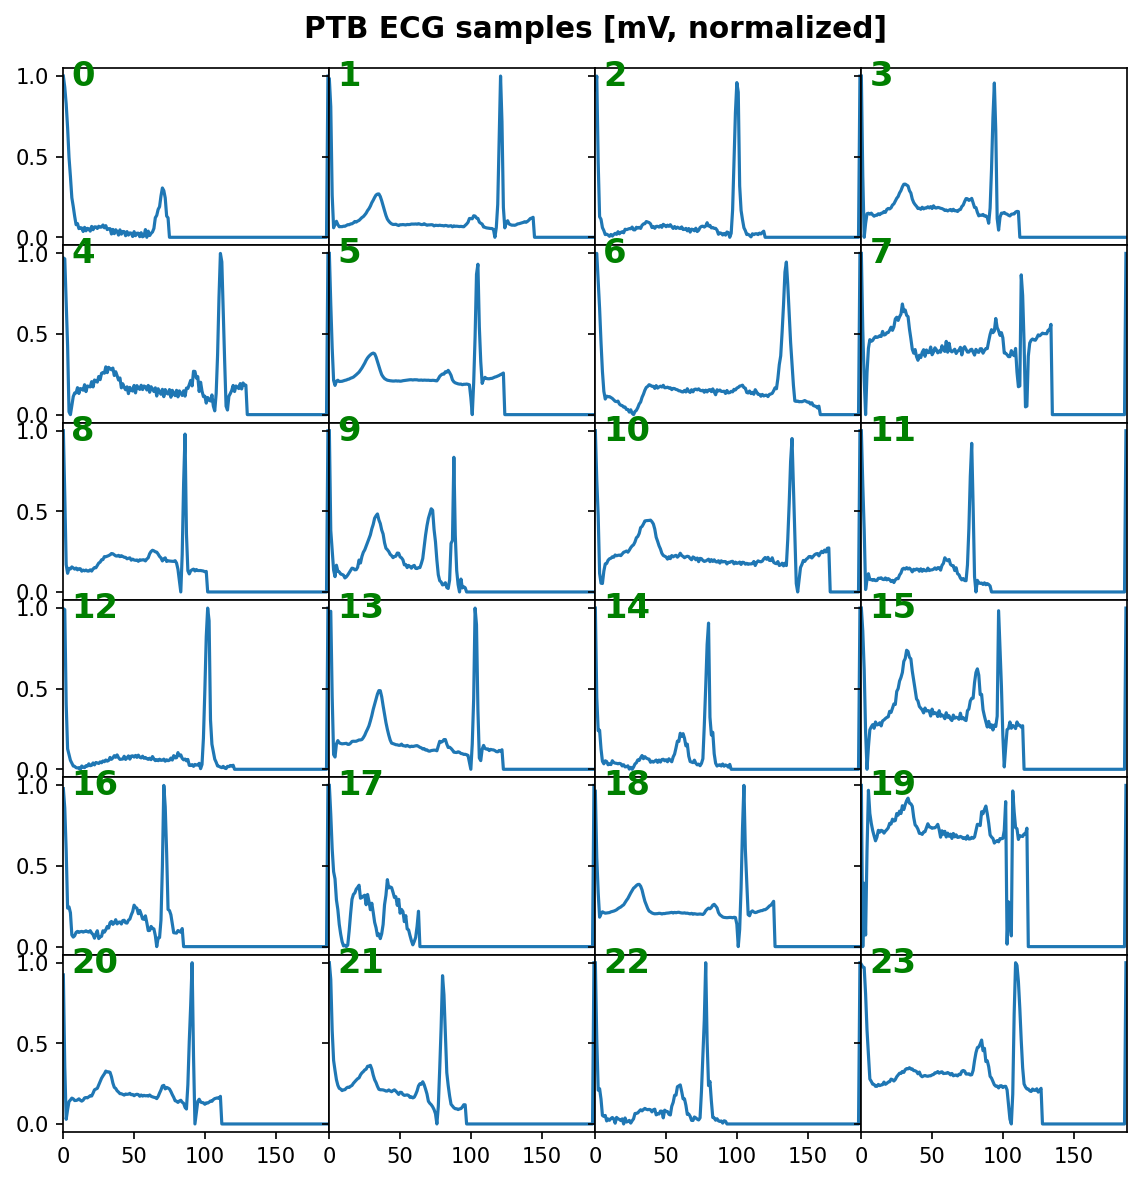

In [4]:
data = tg.val_datagen.batch
_ = features_1D(data[:24], n_rows=6, subplot_samples=True, tight=True,
                title="PTB ECG samples [mV, normalized]")

### Visualize LSTM weights before training

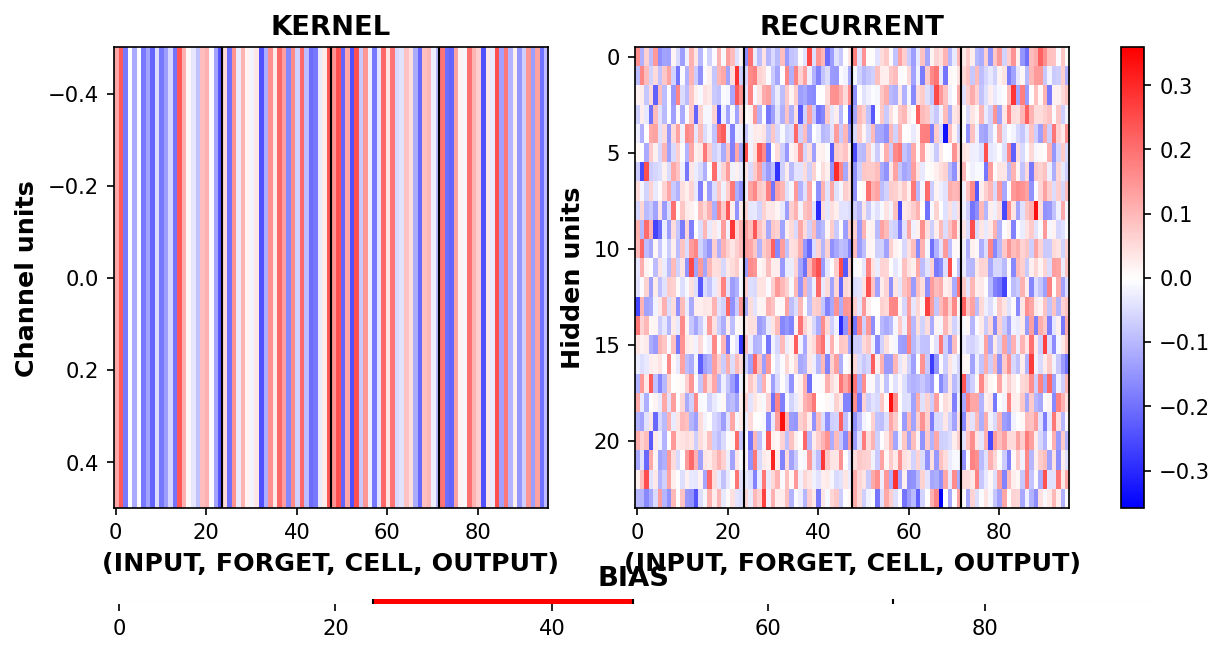

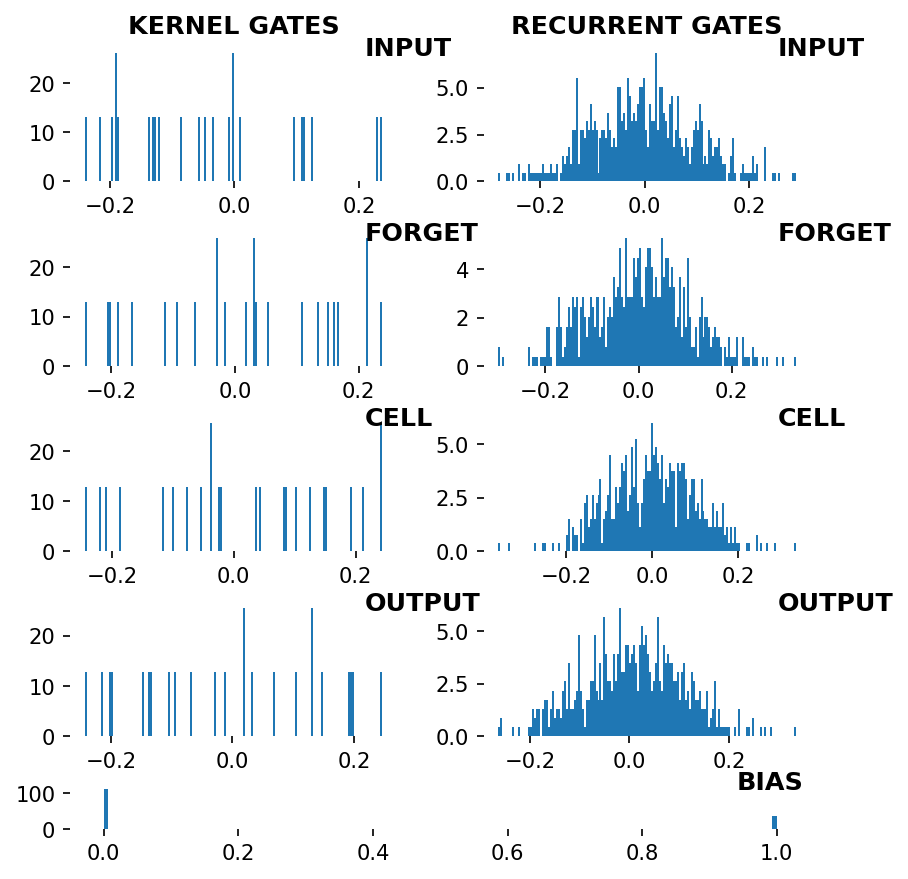

In [5]:
_ = rnn_heatmap(  tg.model, 1, w=.9, h=.9)  # 1 == layer index
_ = rnn_histogram(tg.model, 1, w=.9, h=.9)

### Train


Data set_nums shuffled


_____________________
 EPOCH 1 -- COMPLETE 


Data set_nums shuffled


_____________________
 EPOCH 2 -- COMPLETE 



Validating...
TrainGenerator state saved


C:\deeptrain\deeptrain\visuals.py:577: UserWarning: Attempting to set identical left == right == 1 results in singular transformations; automatically expanding.
  ax.set_xlim(xmin, xmax)


Model report generated and saved
Best model saved to C:\deeptrain\examples\dir\models\M2__model-adam__max.701
TrainGenerator state saved
Model report generated and saved


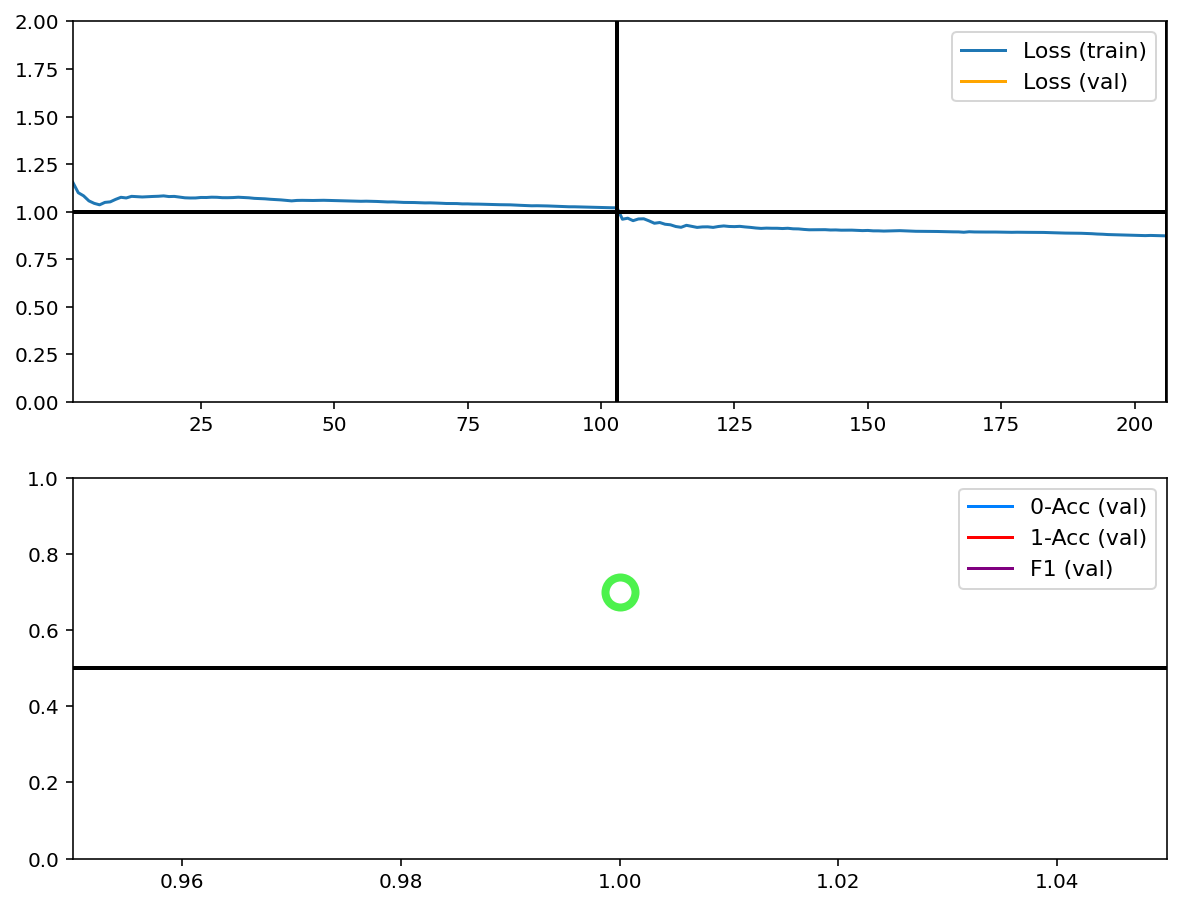

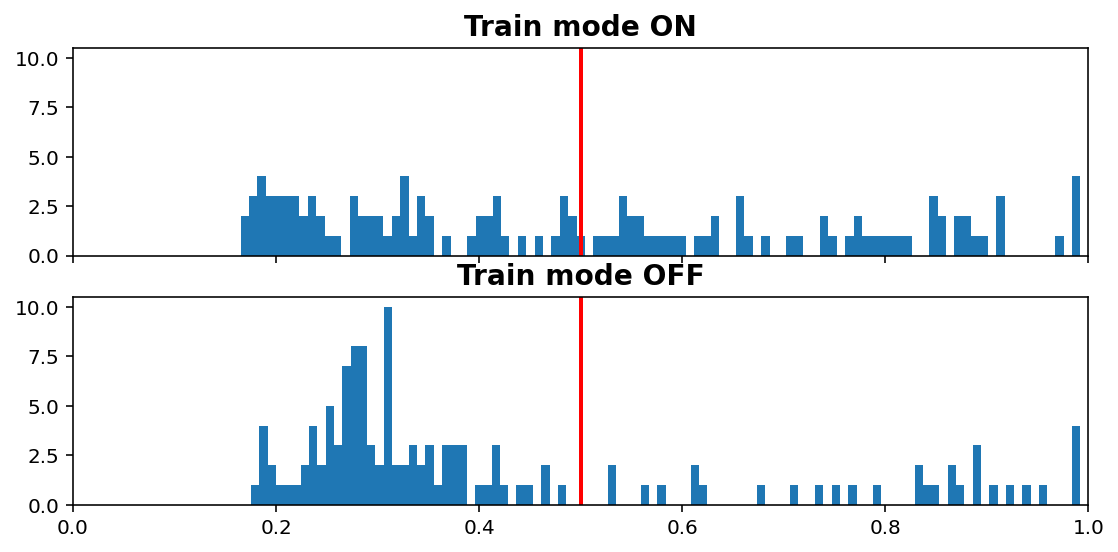

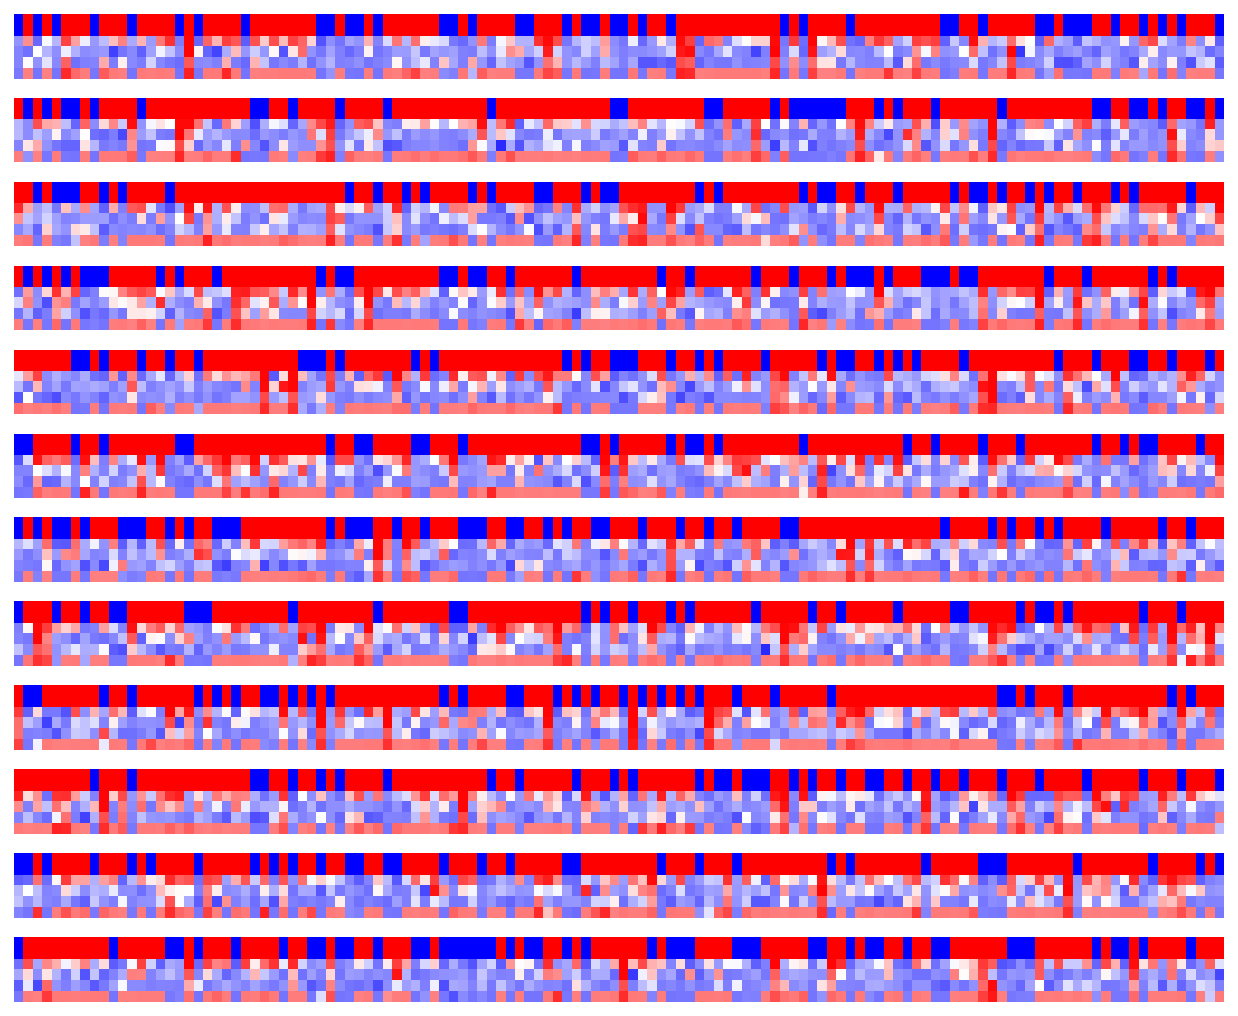

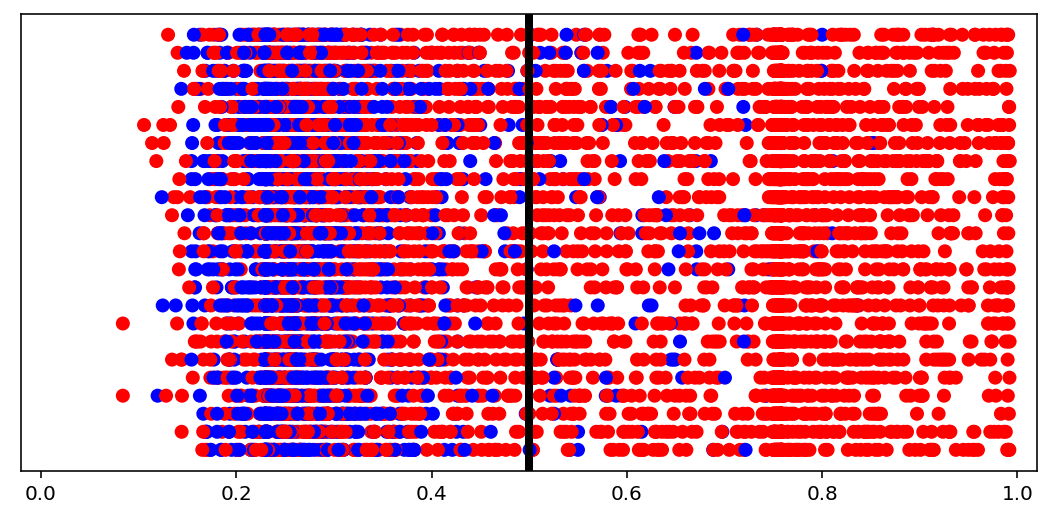


Data set_nums shuffled


_____________________
 EPOCH 3 -- COMPLETE 


Data set_nums shuffled


_____________________
 EPOCH 4 -- COMPLETE 



Validating...
TrainGenerator state saved
Model report generated and saved
Best model saved to C:\deeptrain\examples\dir\models\M2__model-adam__max.792
TrainGenerator state saved
Model report generated and saved


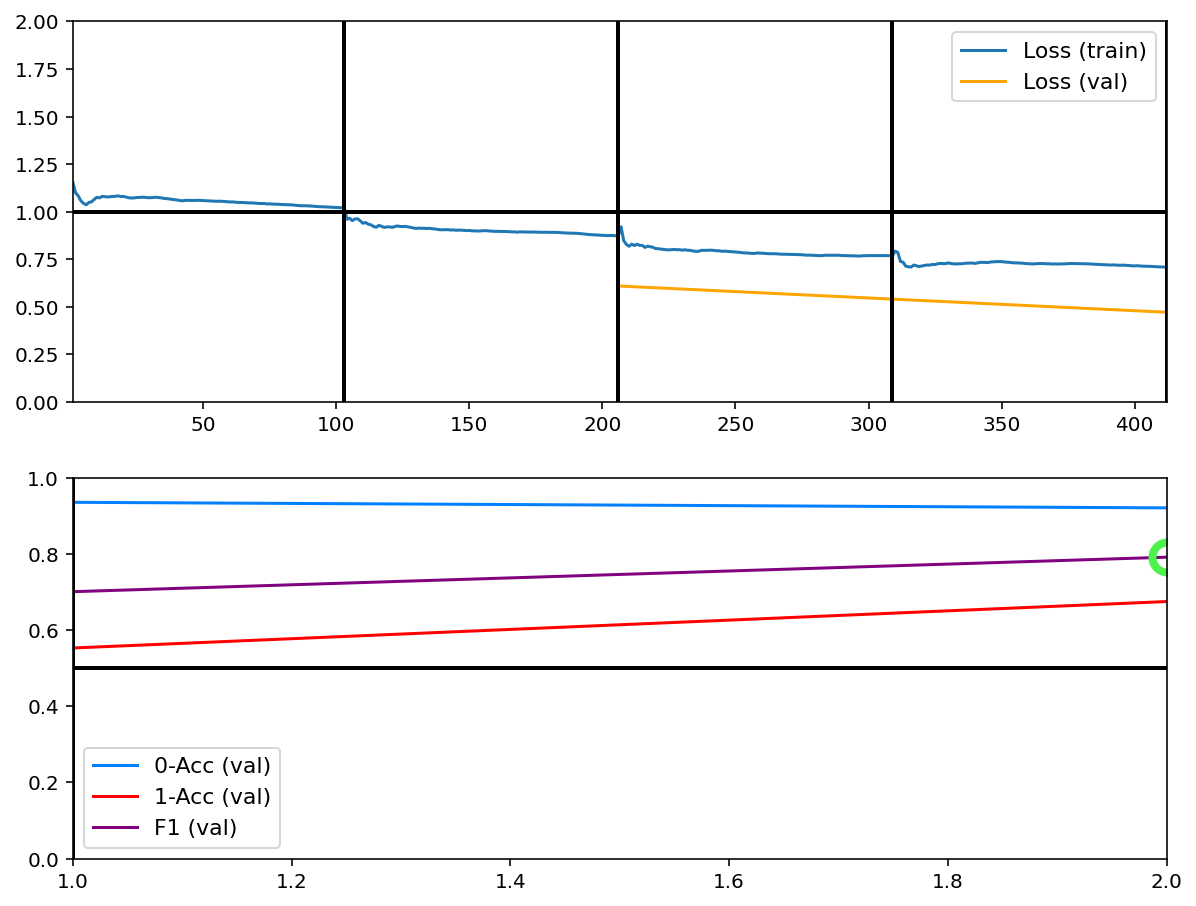

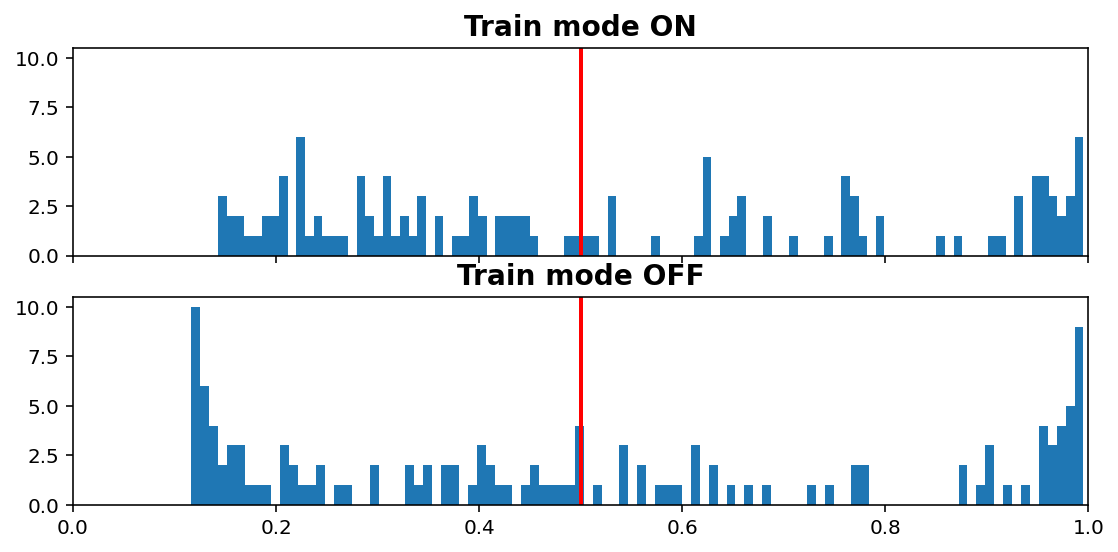

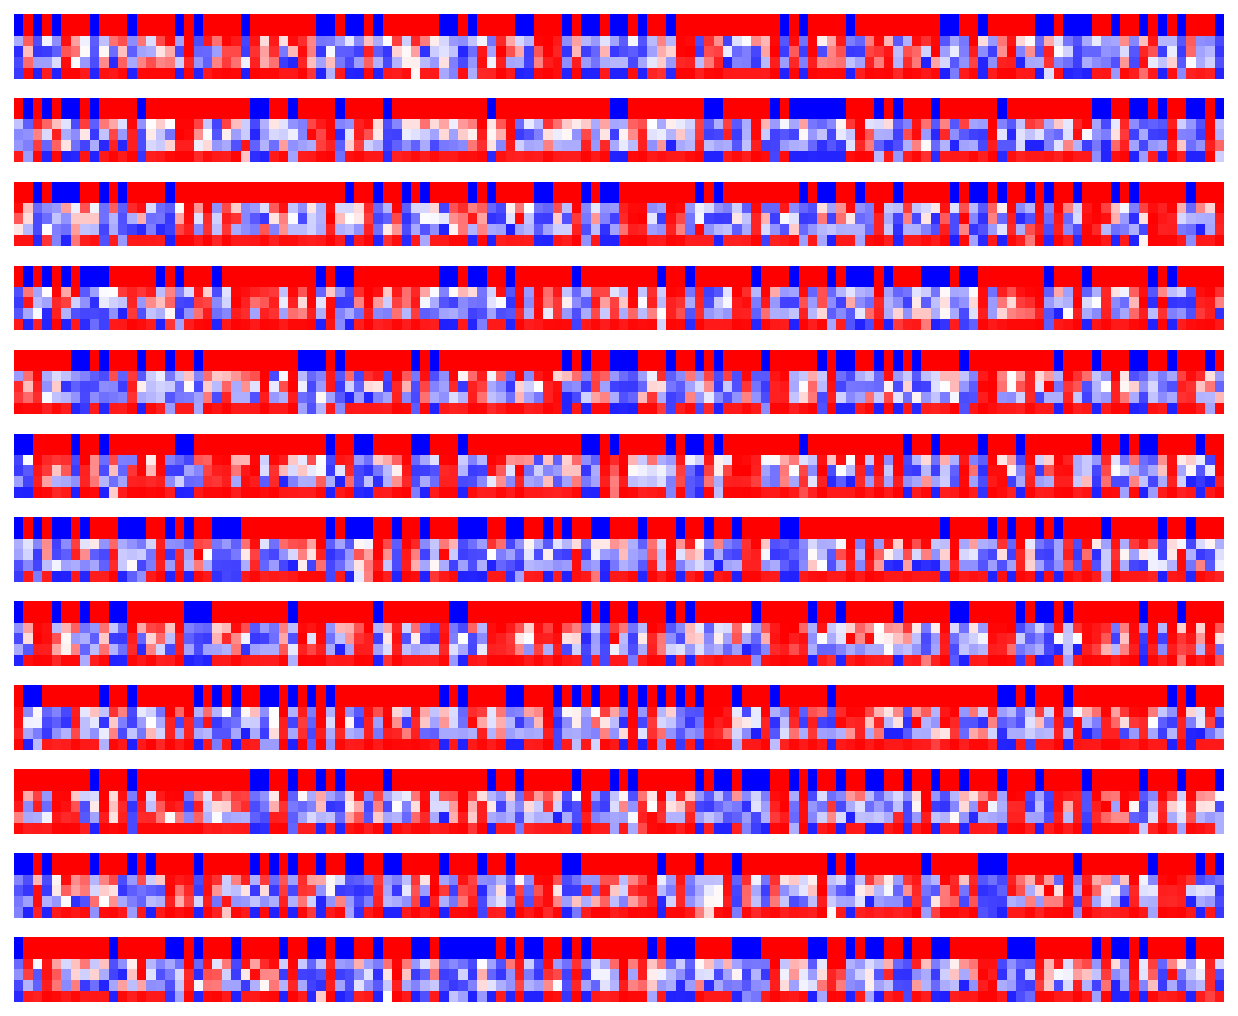

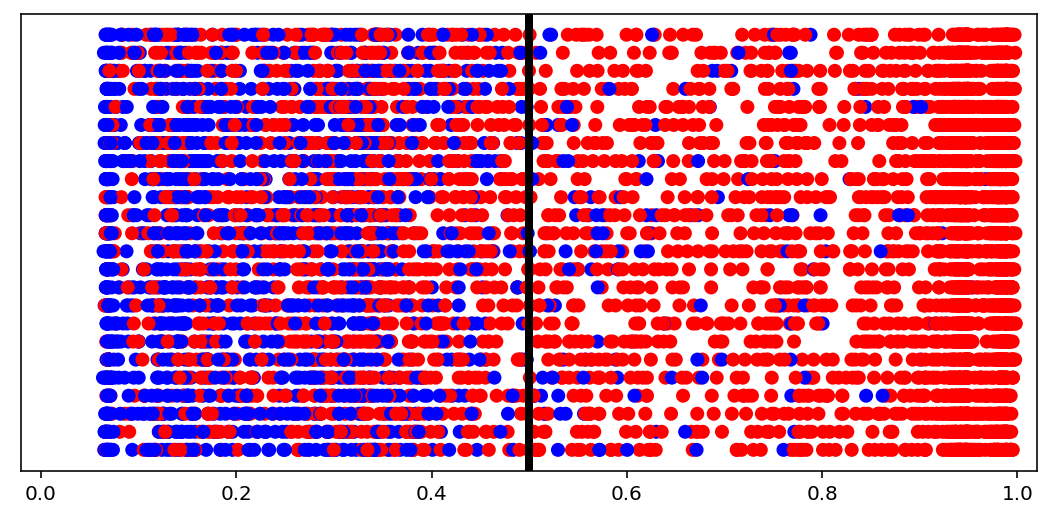

Training has concluded.


In [6]:
tg.train()

### Visualize LSTM weights post-training

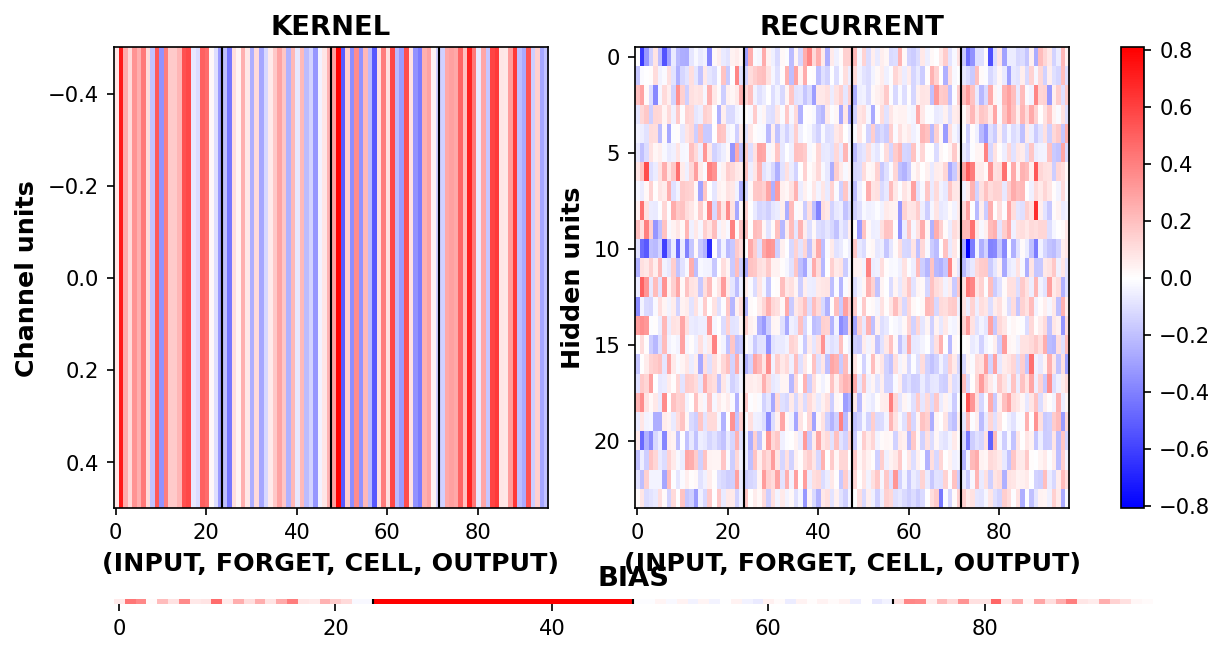

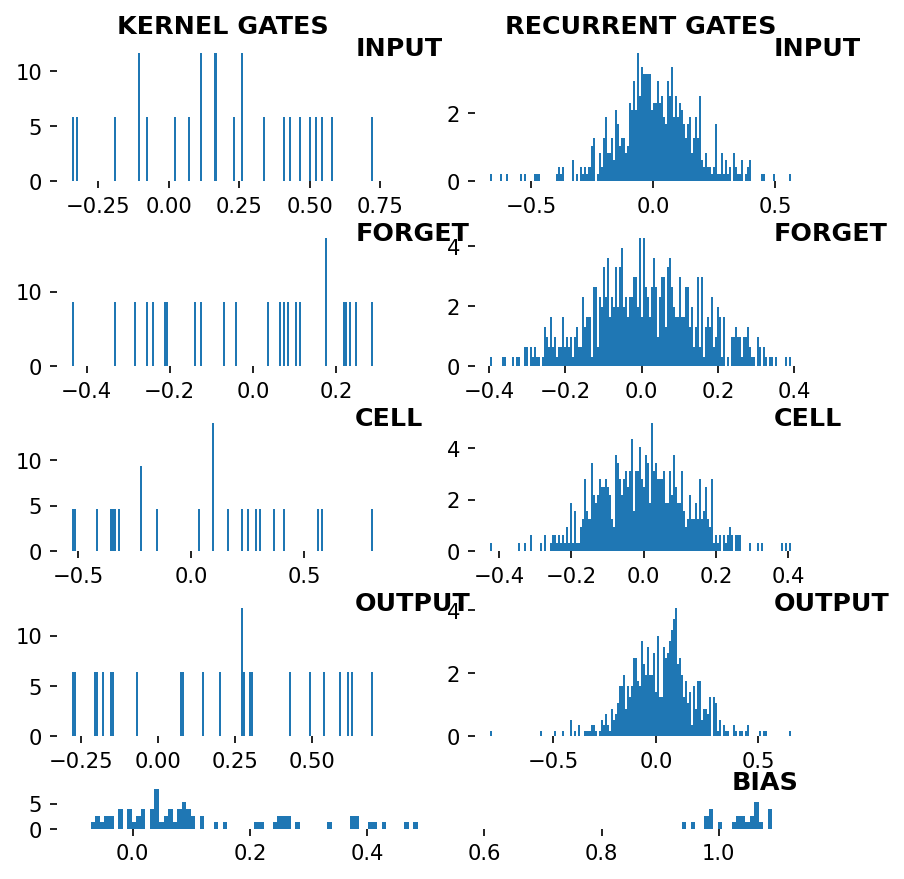

In [7]:
_ = rnn_heatmap(  tg.model, 1, w=.9, h=.9)  # 1 == layer index
_ = rnn_histogram(tg.model, 1, w=.9, h=.9)

Differences are more pronounced when trained longer.

Next we inspect the callback figures; to redraw them, first we re-validate without clearing cache, to then
get predictions & labels from cache for plotting.

In [8]:
tg.validate(clear_cache=False, record_progress=False, use_callbacks=False)



Validating...


### Predictions per iteration

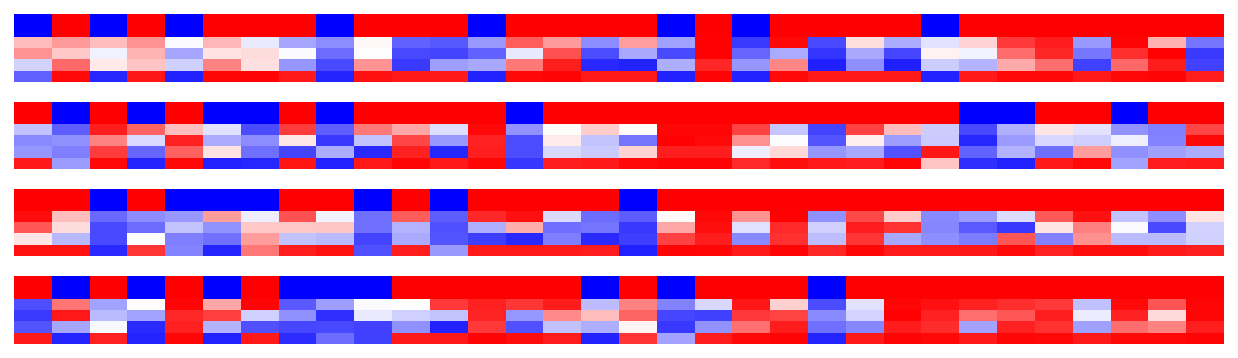

In [9]:
from deeptrain import visuals
import numpy as np

lc = np.asarray(tg._labels_cache)
pc = np.asarray(tg._preds_cache)
# select subset for clearer visual
visuals.binary_preds_per_iteration(lc[:4, :, :32], pc[:4, :, :32], h=.9)

 - Four "sets" for four batches
 - For each set, columns = samples (32)
 - Top of each set are labels, plotted with twice the thickness for clarity
 - Below the labels are the predictions, heatmapped between blue (0) and red (1)
 - Each row of predictions is a timeseries window ("slice")
 
Since the model is stateful, if predictions generaly color corretly toward bottom (later windows), it's indicative of LSTMs utilizing past windows. Here we see no such pattern, but training and tuning were limited.

### Predictions distribution

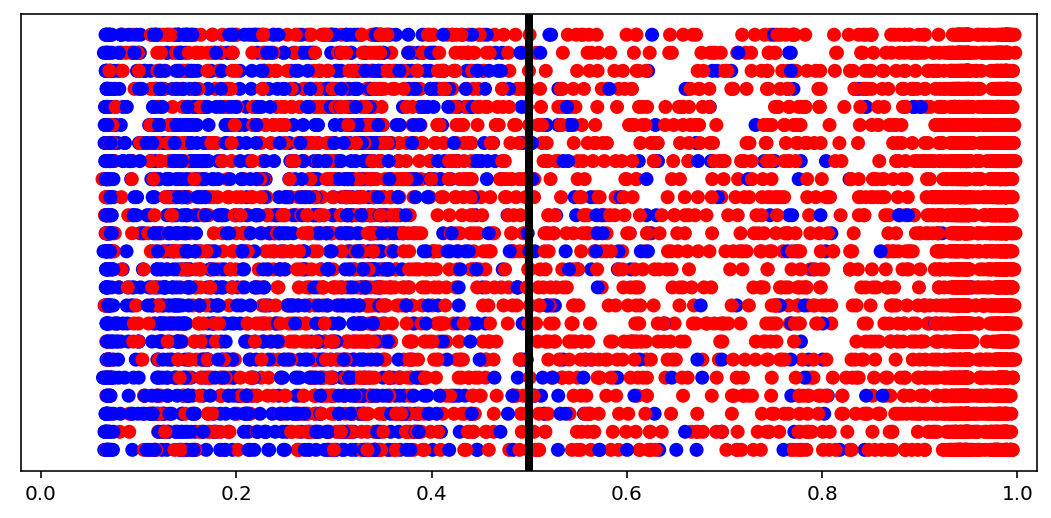

In [10]:
visuals.binary_preds_distribution(lc, pc, pred_th=tg.predict_threshold)

 - Dots = predictions
 - Red  dot at 0.2 = predicted 0.2 for label 1 (red, right of the line = correct)
 - Blue dot at 0.2 = predicted 0.2 for label 0 (blue, left of the line = correct)
 - Vertical line = prediction threshold
 - y-axis is meaningless, vertical space used only to avoid clutter
 
We see more red dots, as expected (0 is minority), and model being biased toward majority class. A better model will have less red on the left, and less blue on the right.<br>
The plot is a good indicator of model "calibration"; sometimes most dots will be either all the way left or all the way right, which may be undesired.

### Inference vs. Train histogram

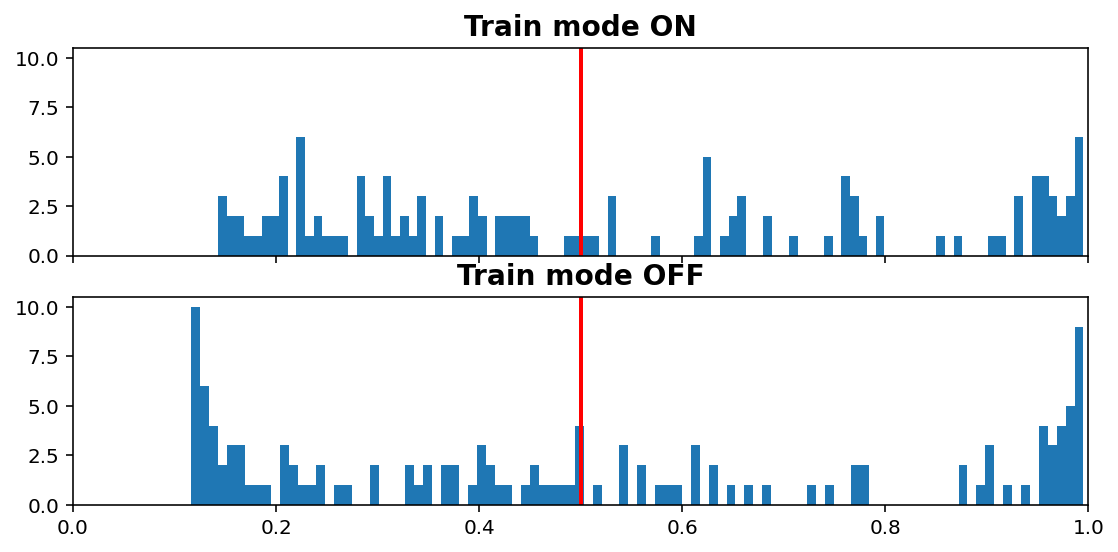

In [11]:
visuals.infer_train_hist(tg.model, tg.val_datagen.get(skip_validation=True)[0],
                         vline=tg.predict_threshold, xlims=(0, 1))

 - "Train mode" refers to the `learning_phase` flag
 - When OFF, Dropout rate is 0, Batch Normalization uses moving average instead of batch statistics, and so on

Increasing dropout rate will make ON vs OFF differences more dramatic. Note that the results are only for one validation window; using all would be expensive as we need to compute twice (train & inference), but is doable (see `introspection.py`). [.](../../_images/ecg.png)[.](../../_images/ecg2.png)[.](../../_images/mnist.gif)[.](../../_images/model_health.png)[.](../../_images/gradients.gif)[.](../../_images/train_loop.png)[.](../../_images/train_val.gif)[.](../../_images/reproducibility.png)[.](../../_images/flexible_batch_size.png)

### Windowed timeseries idea

  - Typical model input shape is `(batch_size, timesteps, input_dim)` (below = `(4, 14, 16)`)
  - In stateful, we break up a whole batch into "windows".
  - If complete sequence had 70 timesteps, then we'll feed 5 windows independently (but in right order),
    then call `model.reset_states()`
  - Relevant: https://stackoverflow.com/a/58277760/10133797

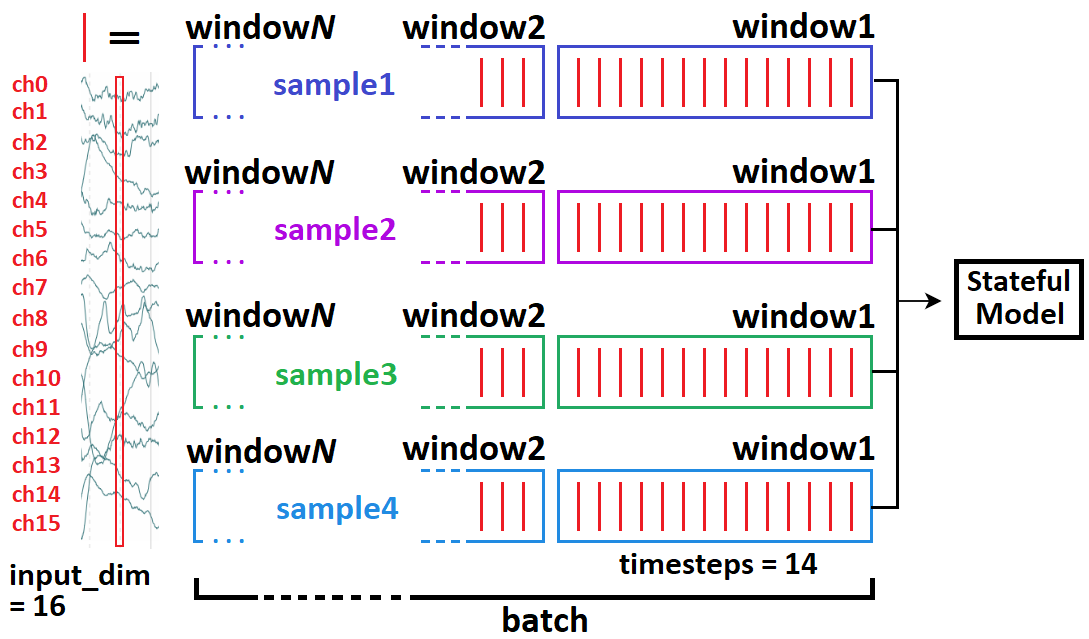

In [12]:
from IPython.display import Image
Image(filename='../../docs/source/_images/timeseries_windows.png', width=600)

See [Preprocessor](preprocessor.html#TimeseriesPreprocessor) example on how `TimeseriesPreprocessor` logic works.